In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np 
from numpy import exp
from scipy.optimize import curve_fit
import pandas as pd
from lmfit import Model, conf_interval, minimize, Minimizer, Parameter, Parameters, report_fit

\begin{equation}
    V_{breakdown} = \frac{Bpd}{e[ln(Apd) - ln(ln(1 + \gamma^{-1}))]}
\end{equation}


\begin{equation}
    A = \frac{\sigma}{k_b T}
\end{equation}

\begin{equation}
    B = \frac{E_{ion} \sigma}{k_b T}
\end{equation}


## Curve Fit Using LMFIT

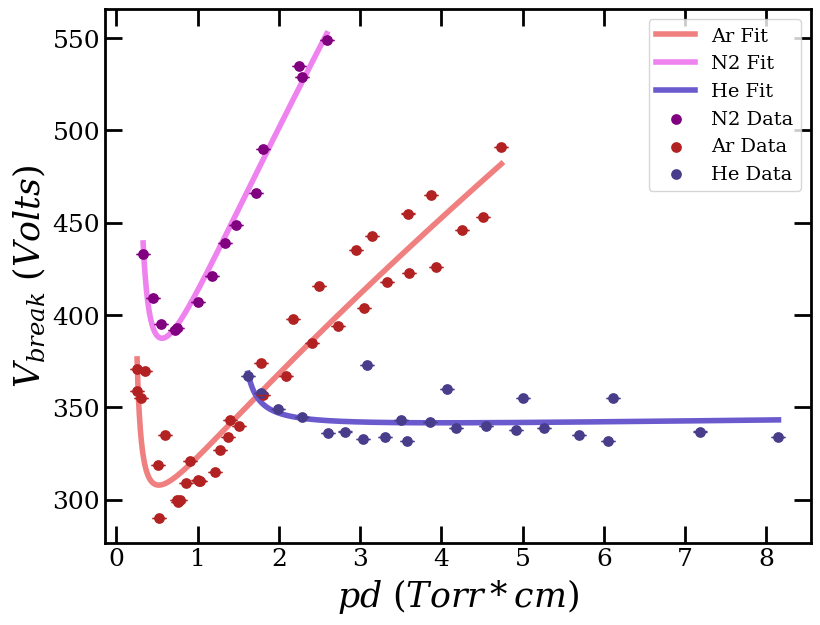

In [14]:
#Read in data for Nitrogen
p1, input_v1, drop_v1, d1, pd = np.loadtxt('Paschen Curve Data - Nitrogen.csv', delimiter = ',', skiprows = 1, dtype = 'float', unpack = True)

#Read in data for Argon
p, input_v, drop_v, d, pd = np.loadtxt('Paschen Curve Data - Copy of Ar.csv', delimiter = ',', skiprows = 1, dtype = 'float', unpack = True)
p_ar, input_v_ar, drop_v_ar, d_ar = np.loadtxt('Paschen Curve Data - Ar_2.csv', delimiter = ',', skiprows = 1, dtype = 'float', unpack = True)

#Read in data for Helium
p_he, input_v_he, drop_v_he, d_he, pd_r = np.loadtxt('Paschen Curve Data - He(1).csv', delimiter = ',', skiprows = 1, dtype = 'float', unpack = True)

#Convert pd to mtorr*cm
pd1 = (p1*(10**(-3)*d1))
pd_he = (p_he*(10**(-3)*d_he))
pd_ar1 = (p_ar*(10**(-3)*d_ar))
pd_ar2 = (p*(10**(-3)*d))

#Concatenate Argon data
v_tot_ar = np.concatenate((input_v, input_v_ar))
pd_tot_ar = np.concatenate((pd_ar2, pd_ar1))
d_tot_ar = np.concatenate((d, d_ar))
p_tot_ar = np.concatenate((p, p_ar))


#The equation for breakdown voltage is as such
def v_break(x, A, B, C, D):
    e = 1.602e-19
    num = B*x
    denom = ((np.log(A*x)) - C)
    result = (num/denom) + D
    return result


#Create LmFit model
model = Model(v_break)

############### NITROGEN FIT ################################################


#Make initial guesses for Nitrogen
param = model.make_params(A = 14.599, B = 364, C = 1.311, D = 200)

#Set minimum for A and C as to not get Nan values in the log term
param['A'].set(min = 1)
param['A'].set(max = 17)

param['C'].set(min = 0.8)
param['C'].set(max = 1.6)

#Fit my results and print the confidence interval
result_N2 = model.fit(input_v1, param, x = pd1)#, nan_policy = 'omit')
#ci = result_N2.ci_report()
#print(ci)
#print(result_N2)


############## ARGON FIT ##################################

#Set initial parameters for Argon 
param['A'].set(value = 13.599)
param['B'].set(value = 235)
param['C'].set(value = 0.9)


#Fit and print results
result_Ar = model.fit(v_tot_ar, param, x = pd_tot_ar)     #, nan_policy = 'omit')
#ci = result_Ar.ci_report()
#print(ci)

########## HELIUM FIT USING LMFIT DID NOT WORK SO I USED CURVEFIT ###########################
# HERE FORCE A TO BE POSITIVE SO THAT THERE IS NO NAN VALUES
#param['A'].set(min = 1)
#param['A'].set(max = 5)
#
#param['C'].set(min = 0.8)
#param['C'].set(max = 1.3)
#
#param['A'].set(value = 2)
#param['B'].set(value = 6)
#param['C'].set(value = 0.96)

result_He = model.fit(input_v_he, param, x = pd_he)#, nan_policy = 'propagate')
#ci = result_He.ci_report()
#print(ci)

#print(result_N2.fit_report())


################# UNCERTAINTY AND ERROR BARS ############################################
d_error = 0.05 #cm

#Assume ~2% uncertainty of any given pressure reading
p_error_n2 = 0.02*(p1*(10**(-3)))
p_error_ar1 = 0.02*(p*(10**(-3)))
p_error_ar2 = 0.02*(p_ar*(10**(-3)))
p_error_ar = np.concatenate((p_error_ar1, p_error_ar2))
p_error_he = 0.02*(p_ar*(10**(-3)))

#pd error for nitrogen
pd_error_n2 = pd1*np.sqrt(((d_error/d1)**2) + ((p_error_n2 / p1)**2))
#print(pd_error_n2)

#pd error for argon
pd_error_ar = pd_tot_ar*np.sqrt(((d_error/d_tot_ar)**2) + ((p_error_ar / p_tot_ar)**2))
#print(pd_error_ar)

#pd error for helium
pd_error_he = pd_he*np.sqrt(((d_error/d_he)**2) + ((p_error_he / p_he)**2))
#print(pd_error_he)



########################### PLOTTTING ##############################################

#Create x and y data for a smooth curve of our fits

#Smooth N2 Fit
x_smooth_N2 = np.linspace(np.min(pd1), np.max(pd1), 1000)
y_smooth_N2 = result_N2.eval(x = x_smooth_N2)

#Smooth Ar Fit
x_smooth_ar = np.linspace(np.min(pd_tot_ar), np.max(pd_tot_ar), 1000)
y_smooth_ar = result_Ar.eval(x = x_smooth_ar)

#Smooth He Fit (I used the values obtained from curve_fit to manually perform this fit)
x_smooth_he = np.linspace(np.min(pd_he), np.max(pd_he), 1000)
y_smooth_he = result_He.eval(x = x_smooth_he, A = 1.7775109, B = 2.08336217, C = 0.96176886, D = 333.37699455)


#Create figure plot
fig, ax = plt.subplots(figsize = (8, 6))

plt.setp(ax.spines.values(), linewidth=2)
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

ax.tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 18)
ax.tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 18)
plt.tight_layout()

plt.plot(x_smooth_ar, y_smooth_ar, zorder = 1, linewidth = 4, color = 'lightcoral', label = 'Ar Fit')
plt.plot(x_smooth_N2, y_smooth_N2, zorder = 1, linewidth = 4, color = 'violet', label = 'N2 Fit')
plt.plot(x_smooth_he, y_smooth_he, zorder = 1, linewidth = 4, color = 'slateblue', label = 'He Fit')
#plt.plot(x_smooth_he, v_break(x_smooth_he, *popt), zorder = 1, linewidth = 4, color = 'slateblue', label = 'He Fit')
plt.scatter(pd1, input_v1, zorder = 1, s = 45, color = 'purple', label = 'N2 Data')
plt.errorbar(pd1, input_v1, yerr = pd_error_n2, fmt = 'none', capsize = 5, color = 'purple')

plt.scatter(pd_tot_ar, v_tot_ar, zorder = 1, s = 45, color = 'firebrick', label = 'Ar Data')
plt.errorbar(pd_tot_ar, v_tot_ar, yerr = pd_error_ar, fmt = 'none', capsize = 5, color = 'firebrick')

plt.scatter(pd_he, input_v_he, zorder = 1, s = 45, color = 'darkslateblue', label = 'He Data')
plt.errorbar(pd_he, input_v_he, yerr = pd_error_he, fmt = 'none', capsize = 5, color = 'darkslateblue')

plt.xlabel(r'$pd~(Torr*cm)$', fontsize = 25)
plt.ylabel(r'$V_{break}~(Volts)$', fontsize = 25)
#plt.xlim(0, 6)
#plt.yscale('log') 
#plt.xscale('log')
plt.legend(loc = 'upper right', fontsize = 14)
plt.savefig('Paschen_Curve.pdf', bbox_inches = 'tight', dpi = 1000)


In [194]:
## Attempt using curve-fit
abs(-(exp(26 / 25) * exp(exp(26 / 25)) / (exp(exp(26 / 25)) - 1) ** 2)) * 23 / 100

0.043406627705701126

### Example of fitting using scipy.curve_fit

C:\Users\Demon\AppData\Local\Temp\ipykernel_27188\3004086469.py:22: RuntimeWarning: invalid value encountered in log
  denom = ((np.log(A*pd)) -  C) #np.log(np.log(1 + (1/gamma))))


[  1.77751098   2.08336217   0.96176886 333.37699455]
[1.36226503e+06 6.06114638e+00 7.66338144e+05 2.34191766e+01]


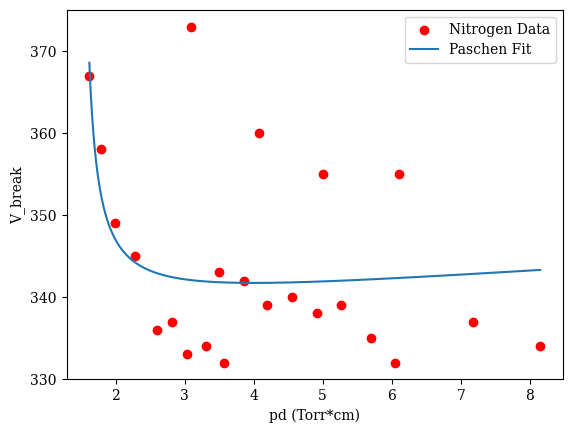

In [ ]:
#Read in data for Helium
p1, input_v1, drop_v1, d1, pd = np.loadtxt('Paschen Curve Data - He(1).csv', delimiter = ',', skiprows = 1, dtype = 'float', unpack = True)

#Convert pd to mtorr*cm
pd1 = (p1*(10**(-3)*d1))

#The equation for breakdown voltage is as such
def v_break(pd, A, B, C, D):
    e = 1.602e-19
    num = B*pd
    denom = ((np.log(A*pd)) -  C) #np.log(np.log(1 + (1/gamma))))
    result = (num/denom) + D
    return result


#Perform the fit with initial guesses that align with actual values
popt, pcov = curve_fit(v_break, pd1, input_v1, p0 = (2.6, 33, 0.58, 50))#, sigma = sigma, absolute_sigma = True)

#Smooth x data for our fit
x = np.linspace(np.min(pd1), np.max(pd1), 1000)

#Plot everything
plt.scatter(pd1, input_v1, label = 'Helium Data', color = 'red')
plt.plot(x, v_break(x, *popt), label = 'Paschen Fit')
#plt.plot(x, y)
plt.ylabel('V_break')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('pd (Torr*cm)')
plt.legend()


#print(popt)
#print(np.sqrt(np.diagonal(pcov)))



### Compute the Resistance of the Plasma

\begin{equation}
    V = IR
\end{equation}

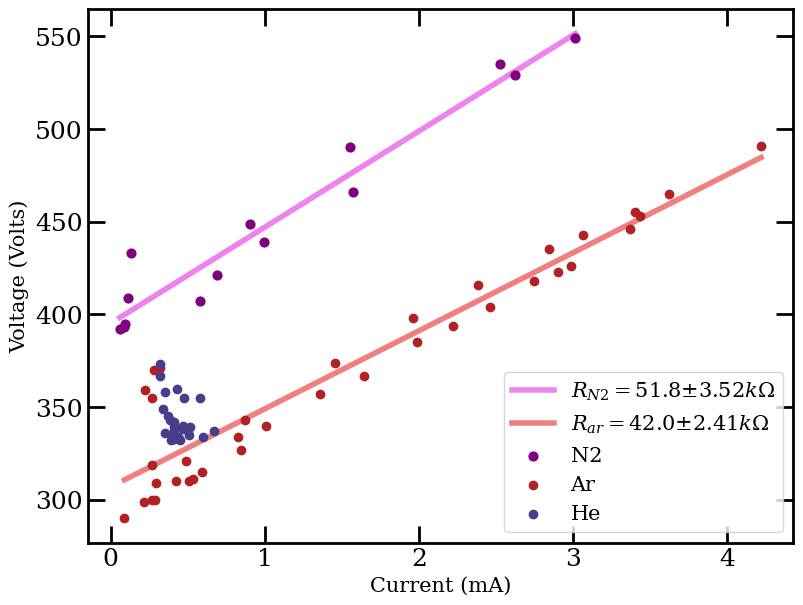

In [42]:
#Read in data for Nitrogen
p1, input_v1, drop_v1, d1, pd = np.loadtxt('Paschen Curve Data - Nitrogen.csv', delimiter = ',', skiprows = 1, dtype = 'float', unpack = True)

#Read in data for Argon
p, input_v, drop_v, d, pd = np.loadtxt('Paschen Curve Data - Copy of Ar.csv', delimiter = ',', skiprows = 1, dtype = 'float', unpack = True)
p_ar, input_v_ar, drop_v_ar, d_ar = np.loadtxt('Paschen Curve Data - Ar_2.csv', delimiter = ',', skiprows = 1, dtype = 'float', unpack = True)

#Read in data for Helium
p_he, input_v_he, drop_v_he, d_he, pd_r = np.loadtxt('Paschen Curve Data - He(1).csv', delimiter = ',', skiprows = 1, dtype = 'float', unpack = True)


#Concatenate Argon data
v_tot_ar = np.concatenate((input_v, input_v_ar))
drop_v_tot = np.concatenate((drop_v, drop_v_ar))
pd_tot_ar = np.concatenate((pd_ar2, pd_ar1))
d_tot_ar = np.concatenate((d, d_ar))
p_tot_ar = np.concatenate((p, p_ar))

R = 53.4*(10**(3))



#Current 
I_n2 = (drop_v1 / R)*(10**3)
I_ar = (drop_v_tot / R)*(10**3)
I_he = (drop_v_he / R)*(10**3)


def ohms_law(I, R, C):
    V = (I*R) + C
    return V

popt_n2, pcov_n2 = curve_fit(ohms_law, I_n2, input_v1)
popt_ar, pcov_ar = curve_fit(ohms_law, I_ar, v_tot_ar)
n2_err = np.sqrt(np.diagonal(pcov_n2))
ar_err = np.sqrt(np.diagonal(pcov_ar))
x_n2_I = np.linspace(np.min(I_n2), np.max(I_n2), 1000)
x_ar_I = np.linspace(np.min(I_ar), np.max(I_ar), 1000)


#Create figure plot
fig, ax = plt.subplots(figsize = (8, 6))

plt.setp(ax.spines.values(), linewidth=2)
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

ax.tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 18)
ax.tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 18)
plt.tight_layout()

plt.plot(x_n2_I, ohms_law(x_n2_I, *popt_n2), zorder = 1, linewidth = 4, color = 'violet', label = r'$R_{N2} = $' + (str(popt_n2[0]))[:4] + r'$ \pm$' + str(n2_err[0])[:4] + r'$k \Omega $')
plt.plot(x_ar_I, ohms_law(x_ar_I, *popt_ar), zorder = 1, linewidth = 4, color = 'lightcoral', label = r'$R_{ar} = $' + (str(popt_ar[0]))[:4] + r'$ \pm$' + str(ar_err[0])[:4] + r'$k \Omega $')

plt.scatter(I_n2, input_v1, zorder = 1, s = 40, color = 'purple', label = 'N2')
plt.scatter(I_ar, v_tot_ar, color = 'firebrick', label = 'Ar')
plt.scatter(I_he, input_v_he, color = 'darkslateblue', label = 'He')



plt.ylabel('Voltage (Volts)', fontsize = 15)
plt.xlabel('Current (mA)', fontsize = 15)
plt.legend(loc = 'lower right', fontsize = 15)
plt.savefig('IV_curve.pdf', bbox_inches = 'tight', dpi = 1000)


